# Beta-Binomial Example

Let's assume we're running a marketing campaign where we have sent emails to 50 people and 20 of them have responded. We want to learn about the response rate to our emails.

The response to each email can be modeled as a Bernoulli distribution (a binomial distribution with one trial), where a success (y = 1) corresponds to a response and a failure (y = 0) corresponds to no response. The parameter θ of this distribution is the response rate, which is unknown and is the quantity we want to infer.

We'll use a beta prior on θ, reflecting our prior belief about the response rate before seeing the data. The beta distribution is a convenient choice because it is a conjugate prior for the binomial distribution, which means that the posterior distribution is also a beta distribution.

## Base R

-   Let's define our prior distribution, and visualize it.

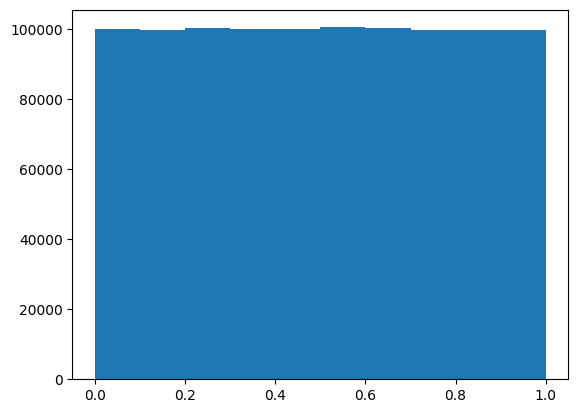

In [6]:
from scipy.stats import beta
from scipy.stats import binom
import matplotlib.pyplot as plt
# Prior hyperparameters
alpha_prior = 1
beta_prior = 1

## Visualize the prior distribution
plt.clf()
plt.hist(beta.rvs(alpha_prior, beta_prior, size = 1000000))
plt.show()

-   Here is a 95% **prior** credible interval for the parameter $\theta$.

In [2]:
# 95% prior credible interval for theta
beta.ppf([0.025, 0.975], alpha_prior, beta_prior)

array([0.025, 0.975])

-   Let's use our data to update the parameters of the posterior distribution, and visualize the distribution in a histogram.

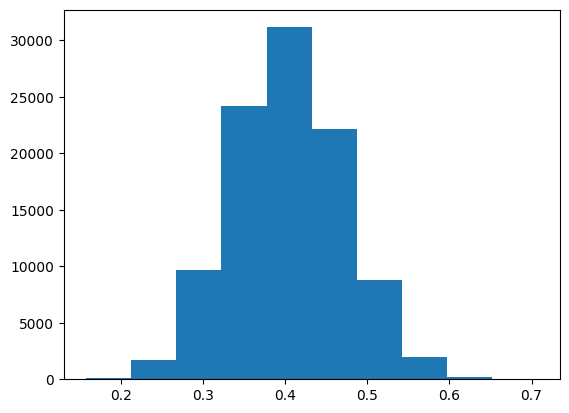

In [3]:
# Data
N = 50 # number of trials
x = 20 # number of successes

# Update parameters
alpha_posterior = alpha_prior + x
beta_posterior = beta_prior + (N - x)

alpha_posterior
beta_posterior

plt.clf()
plt.hist(beta.rvs(alpha_posterior, beta_posterior, size = 100000))
plt.show()

-   Here is a 95% **posterior** credible interval for $\theta$.

In [4]:
# 95% posterior credible interval for theta
beta.ppf([0.025, 0.975], alpha_posterior, beta_posterior)

array([0.27584296, 0.53885901])

-   If we observe **50 new customers,** what is the **predictive distribution** that accounts both for the inherent variablility of the random sample of customers **and** the uncertainty related to the parameter $\theta$?

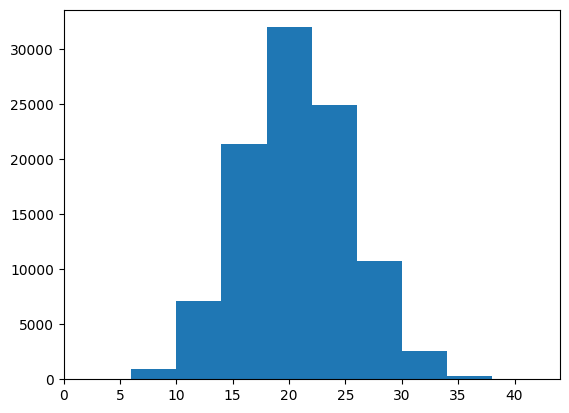

In [7]:
# Predictive distribution of a NEW 50 observations

# Manually
# Pick 100,000 values of theta from prior
theta = beta.rvs(alpha_posterior, beta_posterior, size = 100000)
# Pick 100,000 values from Binomial(n = 50, p = theta)
future_obs = binom.rvs(50, theta, size = 100000)

plt.clf()
plt.hist(future_obs)
plt.show()

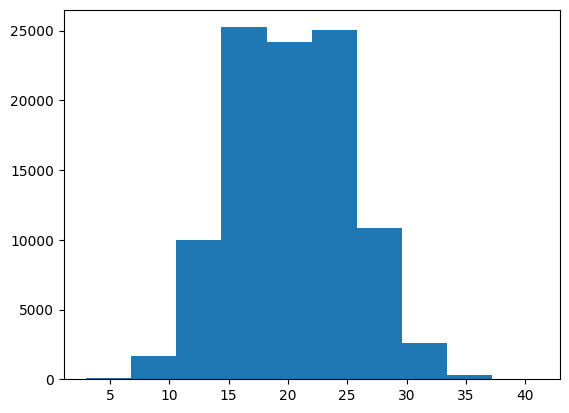

In [8]:
from scipy.stats import betabinom
plt.clf()
plt.hist(betabinom.rvs(50, alpha_posterior, beta_posterior, size = 100000))
plt.show()

-   Notice this is **not the same** as just picking from a binomial distribution - the compound beta-binomial distribution above has more variance.

    -   Look how many more observations are below 10 or above 30.

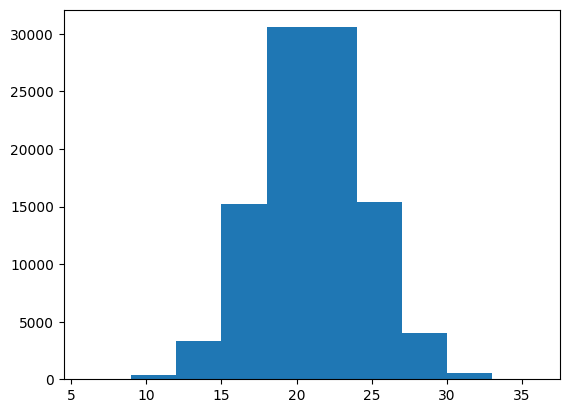

In [9]:
plt.clf()
plt.hist(binom.rvs(50, 21/51, size = 100000))
plt.show()

## Stan

-   Stan is a probabilistic programming language designed for probabilistic computation and Bayesian inference.

-   It is not necessary to use Stan for these simpler models because we have closed-form solutions with conjugate priors.

-   Seeing how Stan is structured reinforces to us how the various model components we've learned about are used - the prior, the likelihood, hyperparameters, predictive distributions, etc

In [ ]:
## Import necessary libraries
from cmdstanpy import CmdStanModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode

# Define Stan model
stan_code = """
data {
  int<lower=0> N; // number of trials
  int<lower=0> y; // number of successes
  real<lower=0> alpha; // prior hyperparameter
  real<lower=0> beta; // prior hyperparameter
}
parameters {
  real<lower=0, upper=1> theta; // probability of success
}
model {
  theta ~ beta(alpha, beta); // prior
  y ~ binomial(N, theta); // likelihood
}
generated quantities {
  int y_pred;
  y_pred = binomial_rng(N, theta); // posterior predictive distribution
}
"""

# Write model to a file
with open("model.stan", "w") as f:
    f.write(stan_code)

# Compile model
model = CmdStanModel(stan_file="model.stan")

In [ ]:
# Data
N = 50  # number of trials
y = 20  # number of successes

# Prior hyperparameters
alpha_prior = 1
beta_prior = 1

# Package data for Stan
stan_data = {"N": N, "y": y, "alpha": alpha_prior, "beta": beta_prior}

# Fit model
fit = model.sample(data=stan_data, iter_sampling=1000, chains=4)

In [ ]:
# Extract posterior samples
posterior_samples = fit.stan_variable()

# Convert to DataFrame
posterior_samples_df = pd.DataFrame(posterior_samples)

# 95% credible interval
ci = np.quantile(posterior_samples_df['theta'], [0.025, 0.975])
print(f"95% credible interval for theta: ({ci[0]}, {ci[1]})")

In [ ]:
# MAP estimate
map_estimate = mode(posterior_samples_df['theta'])[0][0]
print(f"MAP estimate for theta: {map_estimate}")

# Expected value (mean of Beta distribution)
expected_value = np.mean(posterior_samples_df['theta'])
print(f"Expected value for theta: {expected_value}")

In [ ]:
# Posterior predictive samples
y_pred_samples = posterior_samples_df['y_pred']

# Plot posterior predictive distribution
plt.hist(y_pred_samples, density=True)
plt.title("Posterior predictive distribution")
plt.xlabel("y_pred")
plt.show()